## Content
* Packages
* Data Import
* Data Dictionary
* Data Inspection
* Data Cleaning
* Metrics
* Checking for statistical significence (Mean)
* Checking for statistical significence (U-test)
* Sample (Bootstrap).
* Evaluation.
* Communication.

## Packages

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.stats import shapiro

# import statsmodels.stats.api as sms
# from statsmodels.stats.proportion import proportions_ztest, proportion_confint

import plotnine as g

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Data Import

In [3]:
df = pd.read_csv("data/marketing_AB.csv")

## Data Dictionary

- Index: Row index
- user id: Unique user id
- test group: if 'ad' person saw the advertisement, if 'psa' they saw a public service announcement (PSA).
- converted: if a person bought the product then True, else False.
- total ads: The number of Ads/PSA seen by users.
- most ads day: The day that the user saw the highest number of Ads/PSA.
- most ads hour: Hour of the day that the user saw the highest amount of Ads/PSA.

## Data Inspection

In [5]:
df.head(3)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


* There are 588,101 records and 7 variables.
* No missing value detected.

#### Numeric summary

In [9]:
df.select_dtypes("int64").describe()[["total ads", "most ads hour"]]

,total ads,most ads hour
count,588101.000000,588101.000000
mean,24.820876,14.469061
std,43.715181,4.834634
min,1.000000,0.000000
25%,4.000000,11.000000
50%,13.000000,14.000000
75%,27.000000,18.000000
max,2065.000000,23.000000


**`Edit`**
* There is a huge outlier in the total ads/psa column. A maximum number of views of 2,065 compared to 75% of total ads views less than 27 times.

#### Categorical summary

In [11]:
for col in ["test group", "most ads day", "converted"]:

    print(f"\n{col}")
    print("-"*50)
    print("Unique values")
    print(df[col].unique())


test group
--------------------------------------------------
Unique values
['ad' 'psa']

most ads day
--------------------------------------------------
Unique values
['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']

converted
--------------------------------------------------
Unique values
[False  True]


**`Edit`**

* The group variable as expected have only two unique values which are `ad` short for Advertisments and psa short for Public Service Annoucement.
* Moving on to the `most ads day` column, only days of the week from Sunday to Saturday are inclueded on the column.
* Finally, the converted column which is a bool type contain only the two expected variante.

#### Duplicates records

In [12]:
df.duplicated().any()

False

In [14]:
df["user id"].nunique() == df.shape[0]

True

* No `duplicate` record and user

## Data Cleaning

#### Drop duplicated index column

In [4]:
df = df.drop(["Unnamed: 0"], axis=1)

df.columns

Index(['user id', 'test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')

#### Change the `converted` column to binary [0, 1]

In [6]:
df["converted"] = df["converted"].apply(lambda x: 1 if x == True else 0)

df["converted"].unique()

array([0, 1], dtype=int64)

#### Change the `most ads day` column to an ordered category

In [7]:
df["most ads day"] = df["most ads day"].astype("category")

ordered_days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

df["most ads day"] = df["most ads day"].cat.reorder_categories(ordered_days, ordered = True)

df["most ads day"].unique()

['Monday', 'Tuesday', 'Friday', 'Saturday', 'Wednesday', 'Sunday', 'Thursday']
Categories (7, object): ['Sunday' < 'Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday']

#### Clean & Rename columns

In [8]:
df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

df = df.rename(
    columns={
        "test_group": "group", 
        "total_ads": "total_views", 
        "most_ads_day": "most_views_day", 
        "most_ads_hour": "most_views_hour"
    }
)

df.columns

Index(['user_id', 'group', 'converted', 'total_views', 'most_views_day',
       'most_views_hour'],
      dtype='object')

## Metrics

#### The total number of users involved in the experiment

In [24]:
f"{df['user_id'].nunique():,}"

'588,101'

A substantial pool of unique platform users, totaling `588,101`, was randomly selected to participate in the experiment. This sizeable user base provides ample data to assess the effectiveness of the ads effectively.

#### The number of users in the test and control group

In [25]:
temp = (
    c_df["group"]
        .value_counts()
        .reset_index()
        .assign(percentage = lambda _: round((_["count"] / _["count"].sum())*100, 3) )
)

temp

,group,count,percentage
0,Ads,564577,96.0
1,PSA,23524,4.0


Around 96% of the total user base involved in the experiment, totaling 564,577 users, had the opportunity to view the ads at least once. Conversely, a smaller subset, comprising approximately 4% or 23,524 users, did not encounter any ads but were instead presented with a public service announcement.

#### Conversion

The total number of users who participated in the experiment and completed a purchase, regardless of their exposure to the ads, constitutes the conversion count.

In [21]:
temp = (
    c_df["converted"]
     .value_counts()
     .reset_index()
     .assign(percentage = lambda _: round((_["count"] / _["count"].sum())* 100, 2))
)

temp

,converted,count,percentage
0,No,573258,97.48
1,Yes,14843,2.52


A total of 14,843 users, equivalent to 2.52%, successfully converted, indicating that approximately 97.48% of users did not make a purchase during the experiment.

#### Total conversion rates 

In [60]:
round((df["converted"].sum() / df.shape[0]) * 100, 3)

2.524

The overall conversion rate for users on the platform during the experiment period stands at 2.52%, with the remaining 97.48% of users not making any purchases.

#### Total number of converted users in the test & control group

In [26]:
temp = (
    c_df
        .groupby("group")["converted"]
        .value_counts()
        .reset_index()
        .assign(percentage = lambda _: round((_["count"] / _["count"].sum())* 100, 2))
)

temp

,group,converted,count,percentage
0,Ads,No,550154,93.55
1,Ads,Yes,14423,2.45
2,PSA,No,23104,3.93
3,PSA,Yes,420,0.07


We've confirmed that a significant portion of users both viewed the ads and didn't convert, aligning with our previous observation. This trend continues, with approximately 2.45% of users who viewed the ads converting, compared to a mere 0.07% of users who didn't see any ads e.i (they saw a psa).

#### The `Average` ads viwed by users (with min and max)

In [27]:
ads_df = c_df.query("group == 'Ads'")
psa_df = c_df.query("group == 'PSA'")

In [28]:
## Removing outlier

def outlier(df: pd.DataFrame, var: str):

    # calculate the first and third quantiles.
    q1 = np.percentile(df[var], 25)
    q3 = np.percentile(df[var], 75)

    # Calculate the interquartile range (IQR).
    iqr = q3 - q1

    # Calculate lower and upper bounds for potential outliers.
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    return [lower_bound, upper_bound]

In [29]:
ads_df["total_views"].describe()

count    564577.000000
mean         24.823365
std          43.750456
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000
Name: total_views, dtype: float64

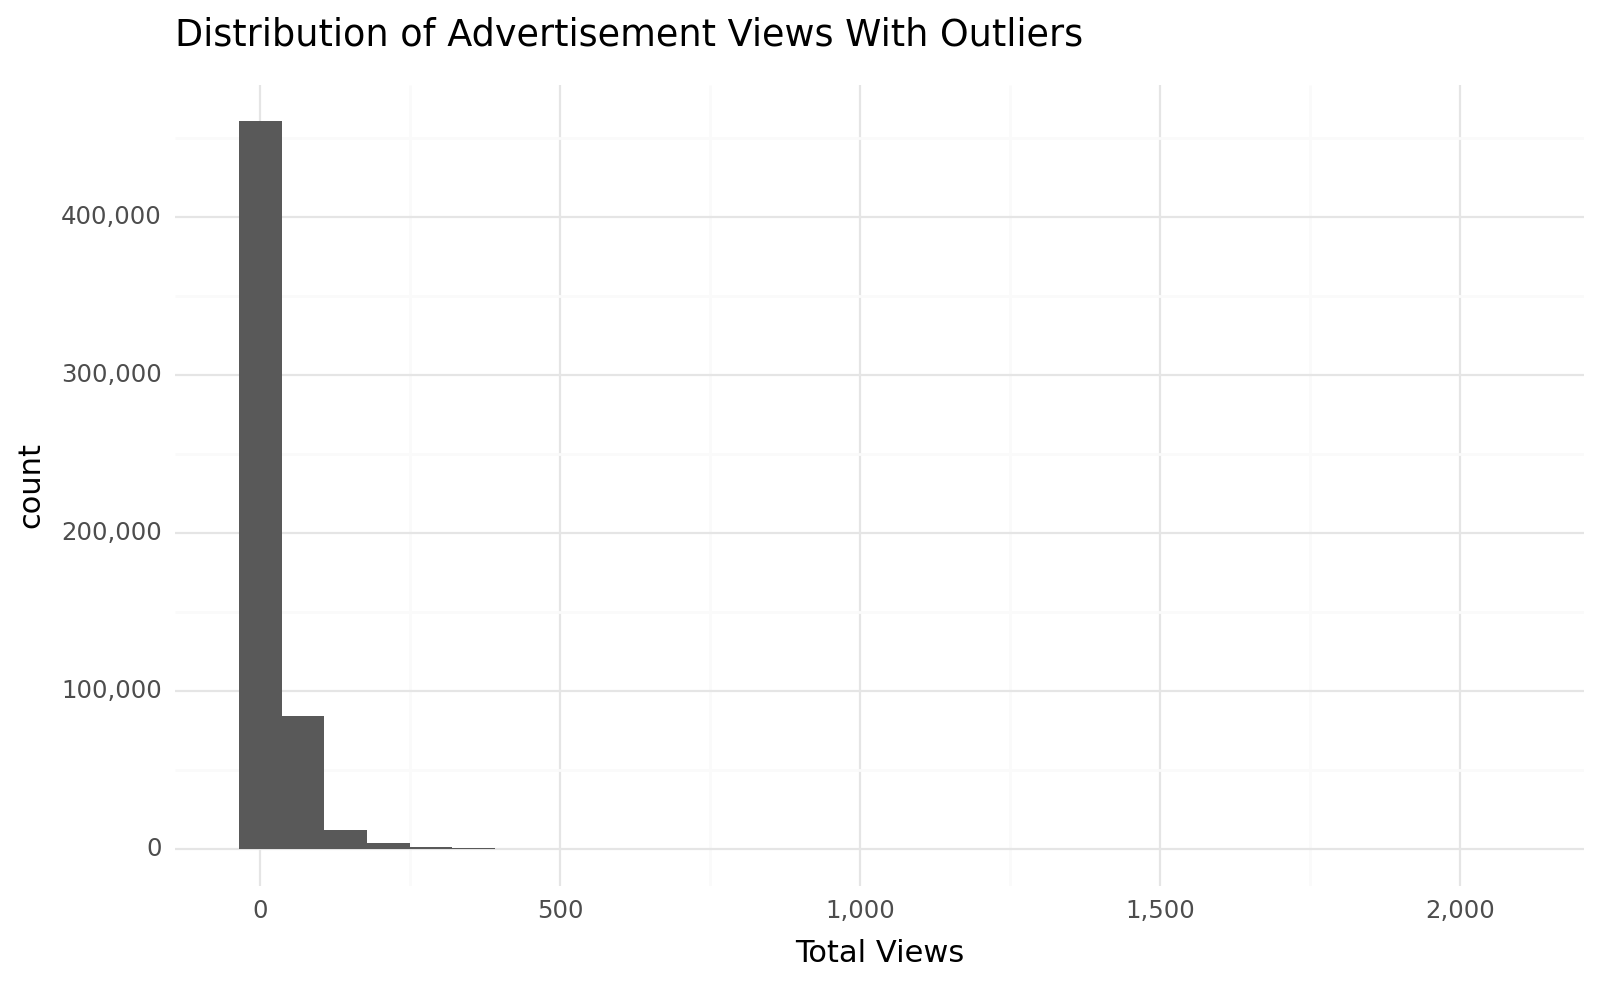

<Figure Size: (800 x 500)>

In [30]:
(
    g.ggplot(ads_df, g.aes(x="total_views")) +
    g.geom_histogram(bins=30) +
    g.scale_x_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l]) +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l]) +
    g.labs(x="Total Views", title="Distribution of Advertisement Views With Outliers") +
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

In [31]:
lower_upper_bound = outlier(ads_df, "total_views")

temp = ads_df.query(f"total_views >= {lower_upper_bound[0]} & total_views <= {lower_upper_bound[1]}")

temp["total_views"].describe()

count    514716.000000
mean         15.159799
std          14.060326
min           1.000000
25%           4.000000
50%          11.000000
75%          22.000000
max          61.000000
Name: total_views, dtype: float64

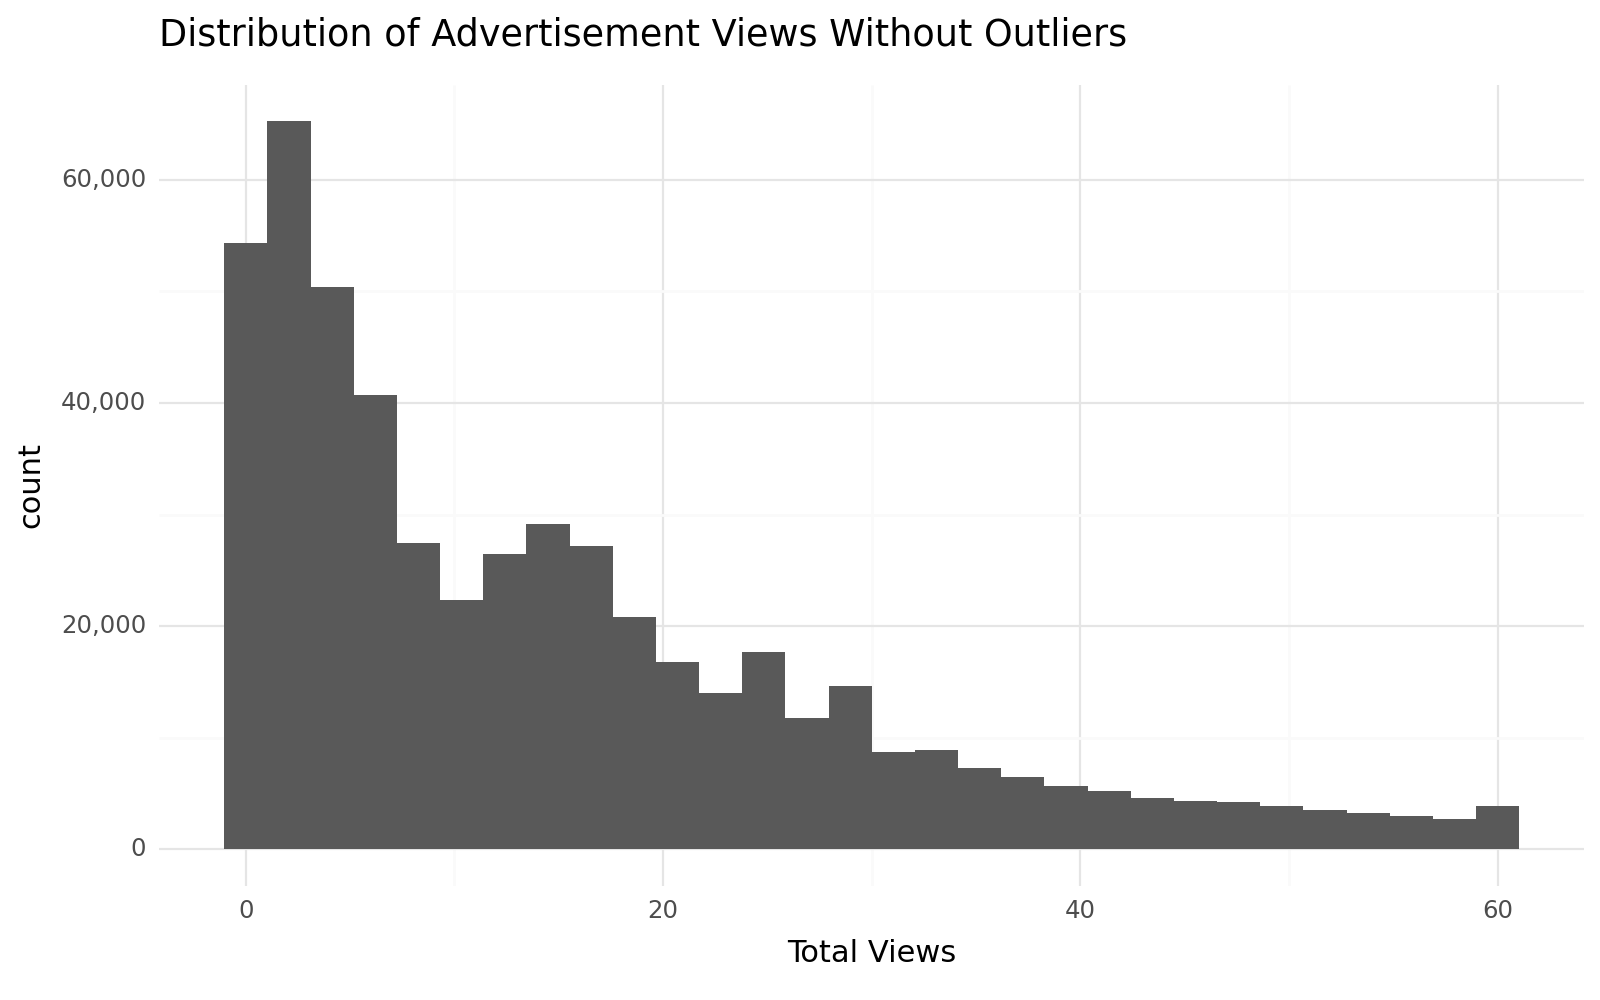

<Figure Size: (800 x 500)>

In [35]:
(
    g.ggplot(temp, g.aes(x="total_views")) +
    g.geom_histogram(bins=30) +
    g.scale_x_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l]) +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l]) +
    g.labs(x="Total Views", title="Distribution of Advertisement Views Without Outliers") +
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

The distribution of total ad views appears to be right-skewed, indicating that there are more users with fewer ad views than those with higher numbers of ad views. Upon removing outliers (users with over 61 ad views), the distribution of total views becomes clearer. It now exhibits an average of 15 views with a standard deviation of 14, as opposed to the average total view of 25 and a standard deviation of 43.75 when including outliers.

#### Are users with more Ads/PSA views converting more then those with less add view?

By taking the median value of 13 views as a reference point, we categorize views above this threshold as "high views" and views below it as "low views."

In [38]:
(
    df
        .assign(above_below = np.where(df["total_views"] >= 13, "Above", "Below"))
        .groupby("above_below")
        ["converted"].agg(["count", "mean"])
        .round(4)
        .reset_index()
)

,above_below,count,mean
0,Above,300849,0.0459
1,Below,287252,0.0036


##### Ads views

In [40]:
 (
    df
    .query("group == 'ad'")
    .assign(above_below = lambda _: np.where(_["total_views"] > 13, "Above", "Below"))
    .groupby("above_below")
    .agg(
        total_converted=pd.NamedAgg(column="converted", aggfunc="sum"),
        num_users = pd.NamedAgg(column="most_views_day", aggfunc="count")
    )
    .reset_index()
    .assign(conversion_rate = lambda _: round((_["total_converted"] / _["num_users"]) * 100, 3))
)

,above_below,total_converted,num_users,conversion_rate
0,Above,13344,277682,4.805
1,Below,1079,286895,0.376


When we analyze the conversion rate in relation to the number of views, we observe that users who viewed the ads more frequently achieved a conversion rate of 4.8%, whereas those with fewer views exhibited a conversion rate of 0.38%.

##### PSA View

In [41]:
 (
    df
    .query("group == 'psa'")
    .assign(above_below = lambda _: np.where(_["total_views"] > 13.45, "Above", "Below"))
    .groupby("above_below")
    .agg(
        total_converted=pd.NamedAgg(column="converted", aggfunc="sum"),
        num_users = pd.NamedAgg(column="most_views_day", aggfunc="count")
    )
    .reset_index()
    .assign(conversion_rate = lambda _: round((_["total_converted"] / _["num_users"]) * 100, 3))
)

,above_below,total_converted,num_users,conversion_rate
0,Above,369,10923,3.378
1,Below,51,12601,0.405


Similar to the pattern seen in ad views, users with a higher number of PSA views also demonstrate a greater conversion rate at 3.378%, in contrast to those with fewer views who show a conversion rate of 0.405%.

#### Total viewes per `day`

##### Ads

In [53]:
(
    c_df.query("group == 'Ads'")["most_views_day"]
        .value_counts()
        .reset_index()
        .assign(percentage = lambda _: round((_["count"] / _["count"].sum())*100, 3))
)

,most_views_day,count,percentage
0,Friday,88805,15.729
1,Monday,83571,14.802
2,Sunday,82332,14.583
3,Thursday,79077,14.006
4,Saturday,78802,13.958
5,Wednesday,77418,13.713
6,Tuesday,74572,13.208


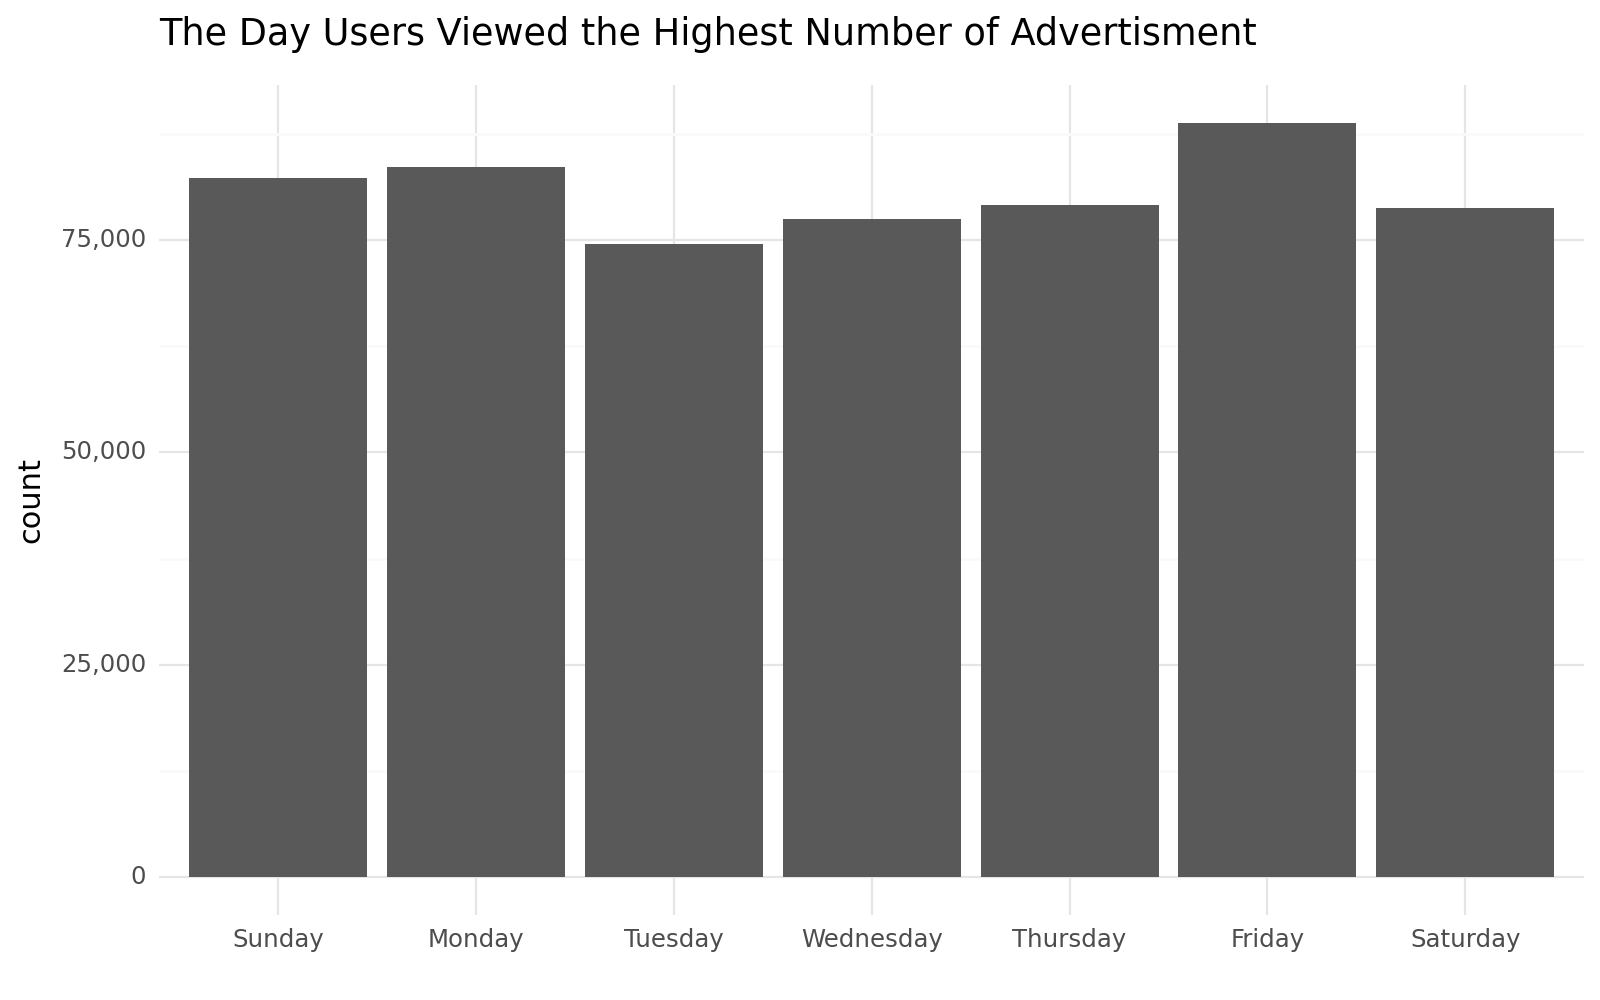

<Figure Size: (800 x 500)>

In [9]:
temp = c_df.query("group == 'Ads'")["most_views_day"].value_counts(sort=False).reset_index()

(
    g.ggplot(temp, g.aes(x="most_views_day", y="count")) +
    g.geom_col() +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l])  +
    g.labs(x="", title="The Day Users Viewed the Highest Number of Advertisment") + 
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

When we scrutinize the days when users viewed the highest number of ads, it becomes evident that Fridays, heading towards the weekend, take the lead with the highest view count, involving 15.72% of users. This is followed by Monday, Sunday, and Thursday. Interestingly, this pattern also indicates how active users are on different days of the week, with Tuesday registering the lowest user engagement for viewing the most ads.

In [11]:
temp = (
    df
    .query("group == 'ad'")
    .groupby("most_views_day")
    .agg(
        total_converted=pd.NamedAgg(column="converted", aggfunc="sum"),
        num_users = pd.NamedAgg(column="most_views_day", aggfunc="count")
    )
    .reset_index()
    .assign(conversion_rate = lambda _: round((_["total_converted"] / _["num_users"]) * 100, 3))
)

temp

,most_views_day,total_converted,num_users,conversion_rate
0,Sunday,2027,82332,2.462
1,Monday,2778,83571,3.324
2,Tuesday,2270,74572,3.044
3,Wednesday,1963,77418,2.536
4,Thursday,1711,79077,2.164
5,Friday,1995,88805,2.246
6,Saturday,1679,78802,2.131


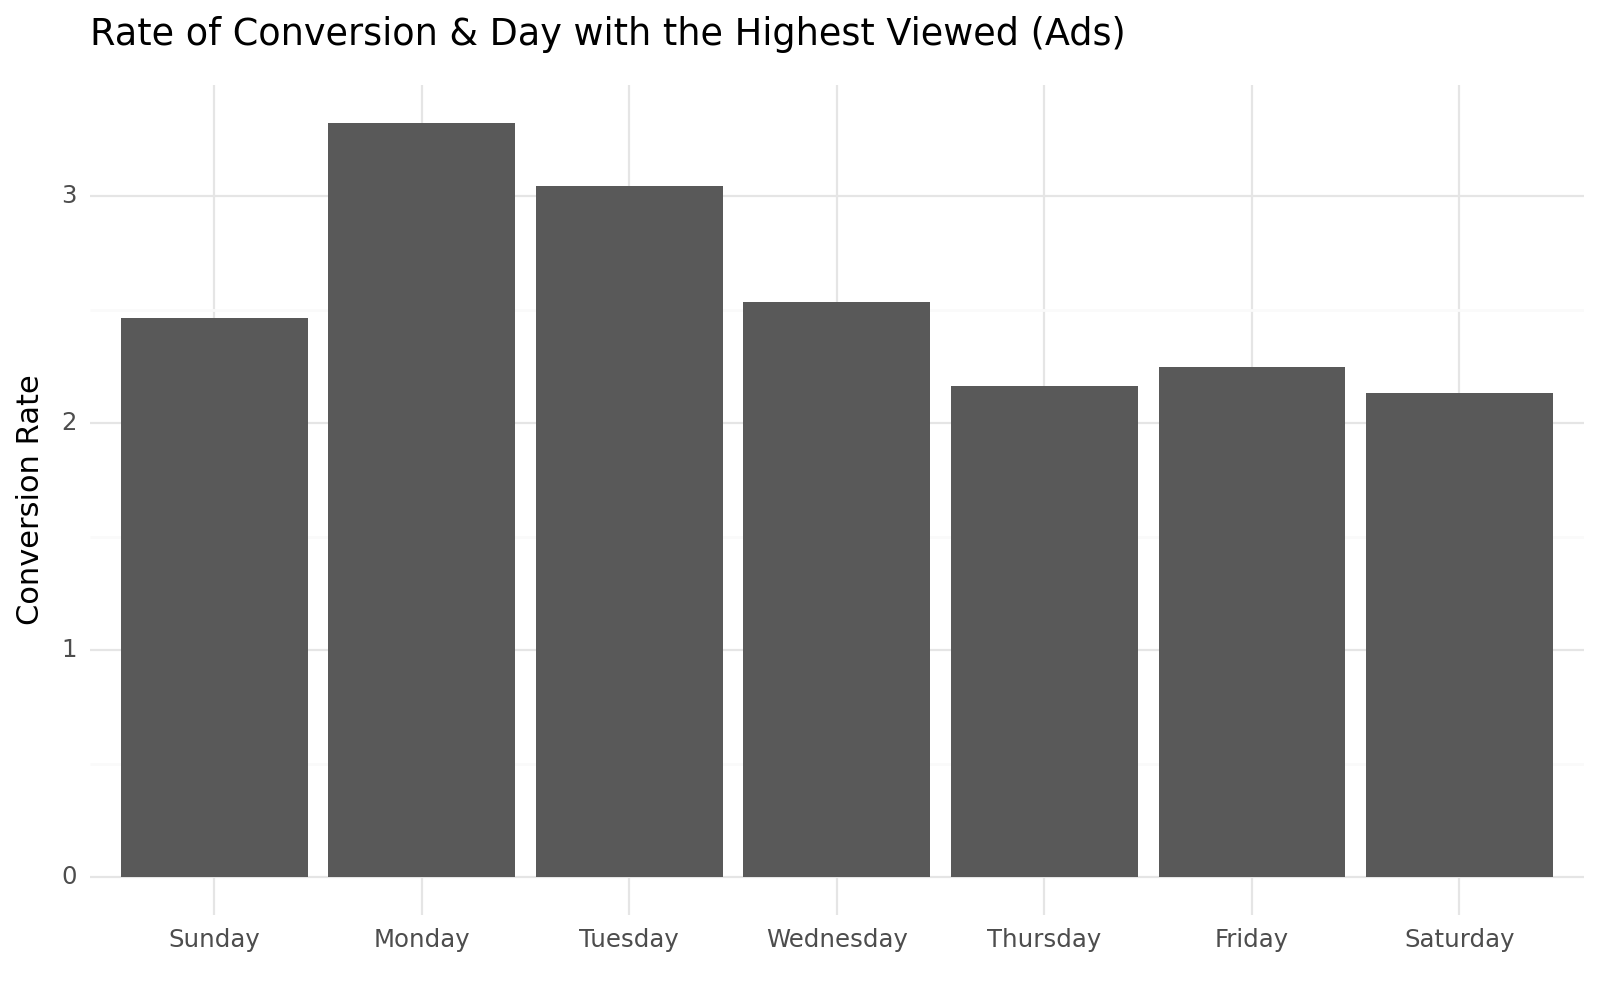

<Figure Size: (800 x 500)>

In [13]:
(
    g.ggplot(temp, g.aes(x="most_views_day", y="conversion_rate")) +
    g.geom_col() +
    g.labs(x="", y="Conversion Rate", title="Rate of Conversion & Day with the Highest Viewed (Ads)") + 
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

Even though Friday boasts the highest number of users viewing their most-viewed ad on a single day, it surprisingly records one of the lowest conversion rates at 2.25%. In contrast, Monday stands out with the highest number of users who converted, achieving a conversion rate of 3.32%. Adding to the surprise, Tuesday, which had the lowest user engagement in terms of the most ad views on a single day, surprisingly secures the second-highest conversion rate at 3.04%.

##### PSA

In [52]:
(
    c_df.query("group == 'PSA'")["most_views_day"]
        .value_counts()
        .reset_index()
        .assign(percentage = lambda _: round((_["count"] / _["count"].sum())*100, 3))
)

,most_views_day,count,percentage
0,Thursday,3905,16.600
1,Friday,3803,16.166
2,Monday,3502,14.887
3,Wednesday,3490,14.836
4,Sunday,3059,13.004
5,Tuesday,2907,12.358
6,Saturday,2858,12.149


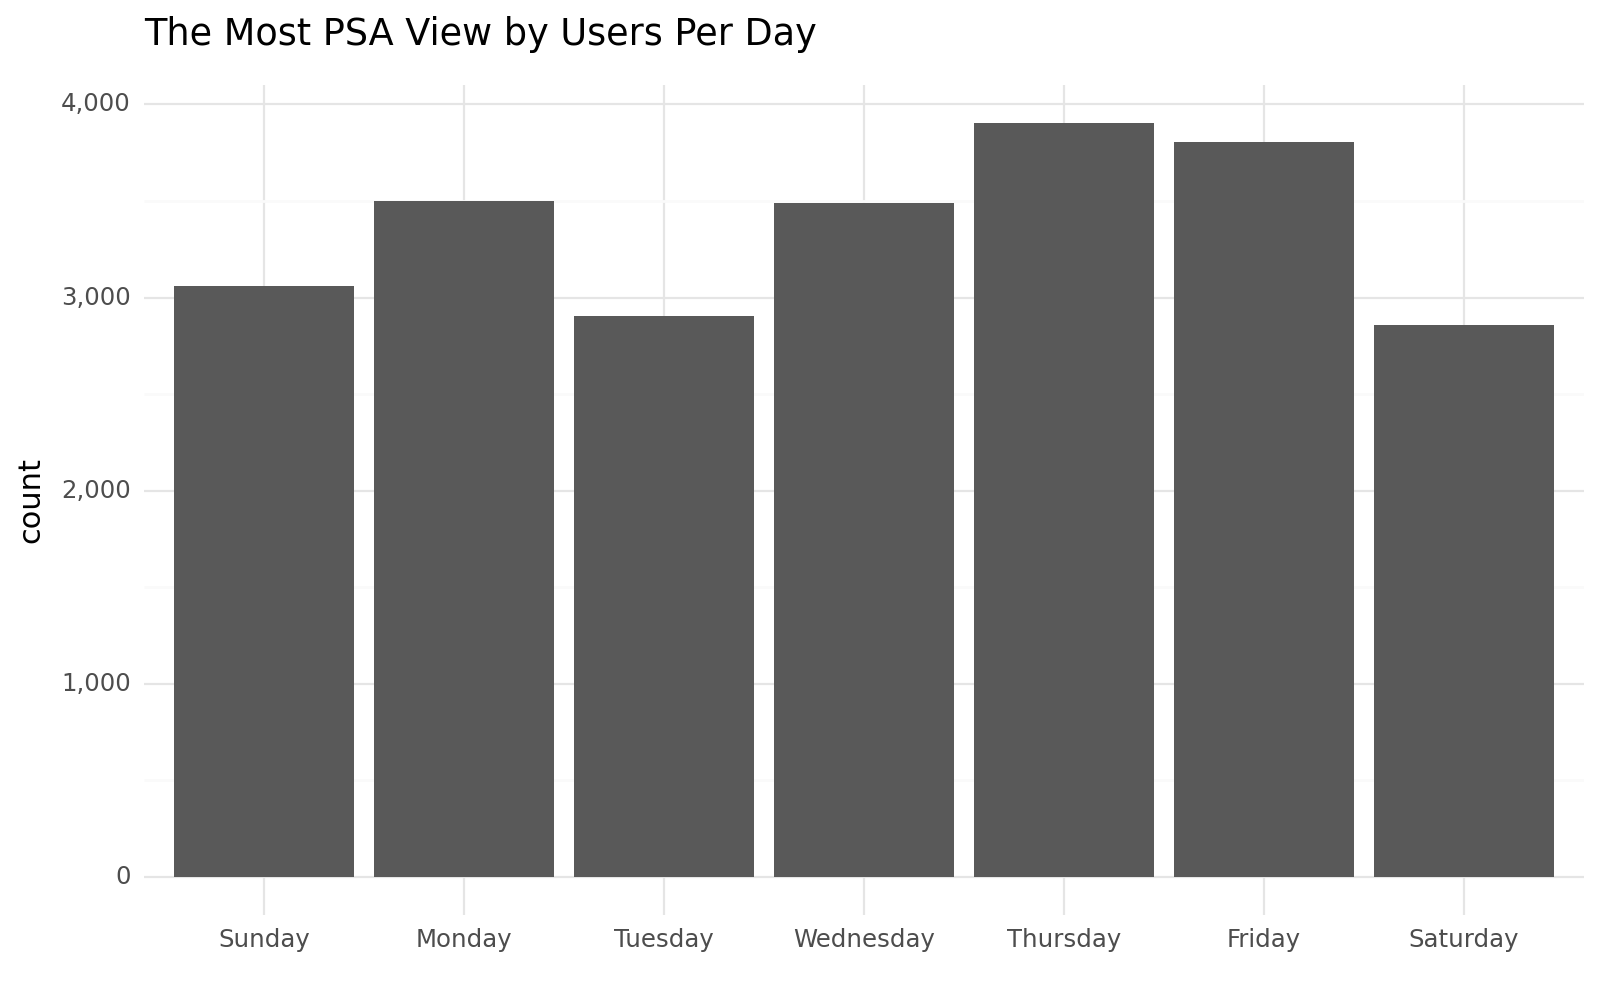

<Figure Size: (800 x 500)>

In [51]:
temp = c_df.query("group == 'PSA'")["most_views_day"].value_counts(sort=False).reset_index()

(
    g.ggplot(temp, g.aes(x="most_views_day", y="count")) +
    g.geom_col() +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l])  +
    g.labs(x="", title = "The Most PSA View by Users Per Day") +
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

Differing from users' ad views, the day with the highest number of `"public service announcement"` views occurred on Thursday, closely followed by Friday, with each accounting for approximately 16% of users. Meanwhile, Monday and Wednesday are also notable for their engagement levels, while Saturday records the lowest user activity, with Tuesday not far behind.

In [55]:

temp = (
    df
    .query("group == 'psa'")
    .groupby("most_views_day")
    .agg(
        total_converted=pd.NamedAgg(column="converted", aggfunc="sum"),
        num_users = pd.NamedAgg(column="most_views_day", aggfunc="count")
    )
    .reset_index()
    .assign(conversion_rate = lambda _: round((_["total_converted"] / _["num_users"]) * 100, 3))
)

temp

,most_views_day,total_converted,num_users,conversion_rate
0,Sunday,63,3059,2.059
1,Monday,79,3502,2.256
2,Tuesday,42,2907,1.445
3,Wednesday,55,3490,1.576
4,Thursday,79,3905,2.023
5,Friday,62,3803,1.630
6,Saturday,40,2858,1.400


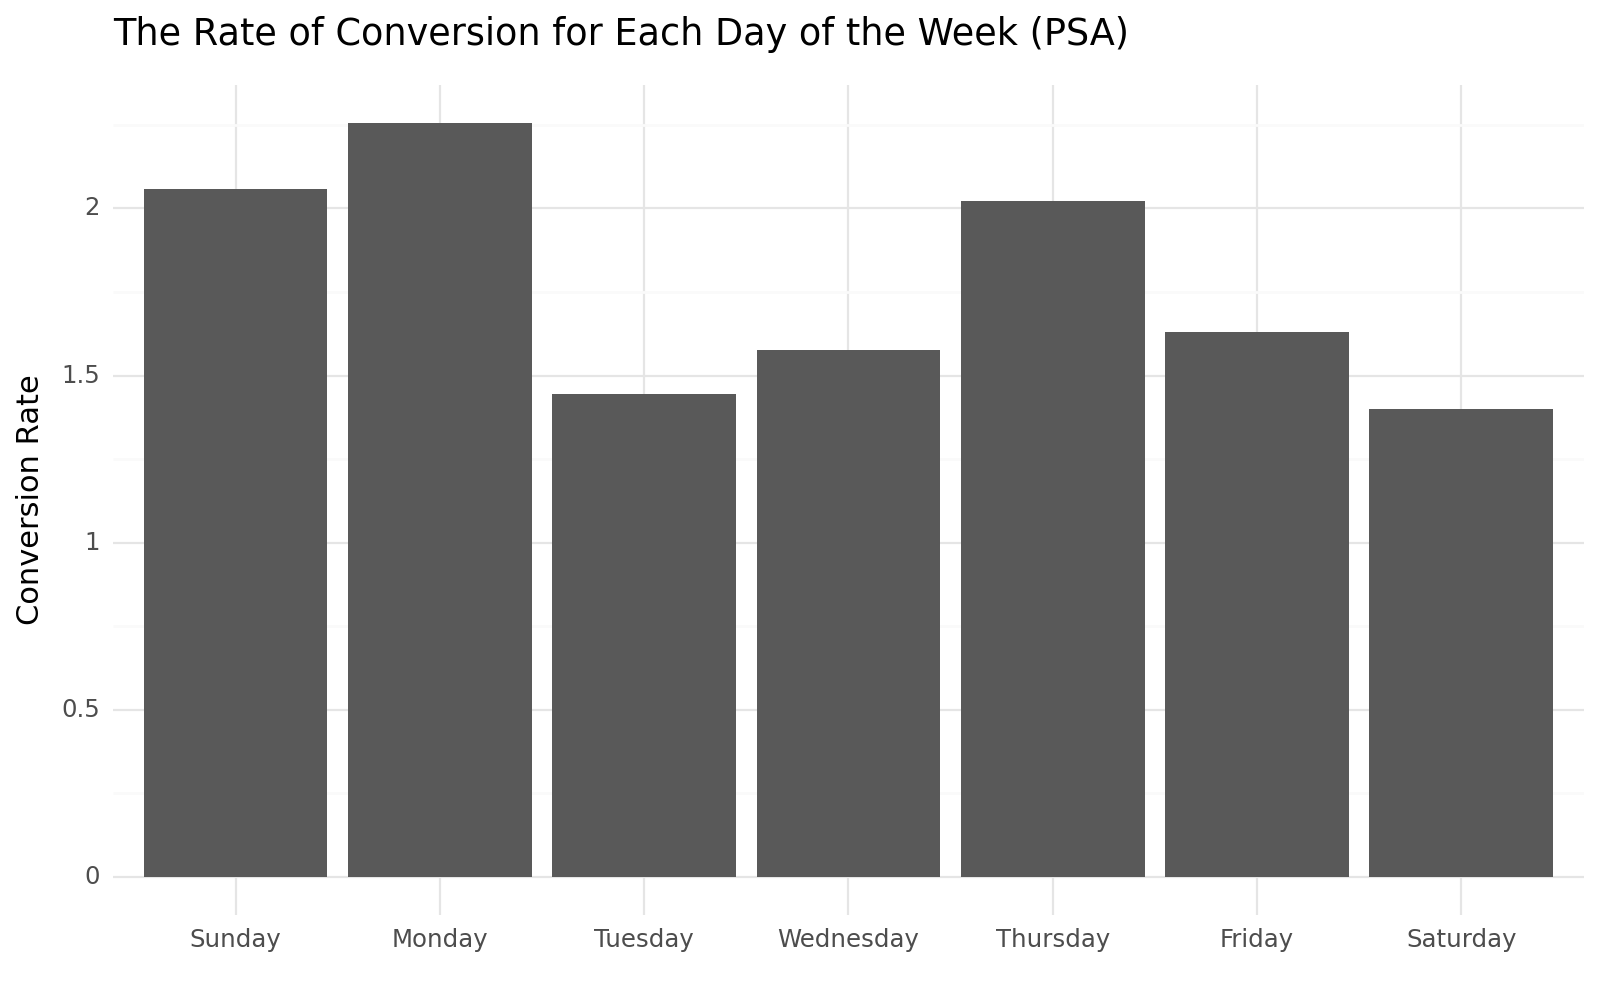

<Figure Size: (800 x 500)>

In [56]:
(
    g.ggplot(temp, g.aes(x="most_views_day", y="conversion_rate")) +
    g.geom_col() +
    g.labs(x="", y="Conversion Rate", title="The Rate of Conversion for Each Day of the Week (PSA)") +
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

When we examine the conversion rate in relation to the days with the most PSA views, a distinct narrative emerges compared to the overall view count.  Monday, despite being the third-highest day in terms of views, records the highest number of users who converted. Following closely behind is Thursday, while Saturday registers the lowest number of users who converted despite its view count.

#### Total views per `hour`

##### Ads

In [57]:
(
    c_df.query("group == 'Ads'")["most_views_hour"]
        .value_counts()
        .reset_index()
        .assign(percentage = lambda _: round((_["count"] / _["count"].sum())*100, 3))
)

,most_views_hour,count,percentage
0,13,45485,8.056
1,12,45238,8.013
2,11,44149,7.820
3,14,43779,7.754
4,15,42855,7.591
5,10,37454,6.634
6,16,35963,6.370
7,17,33605,5.952
8,18,31052,5.500
9,9,29802,5.279


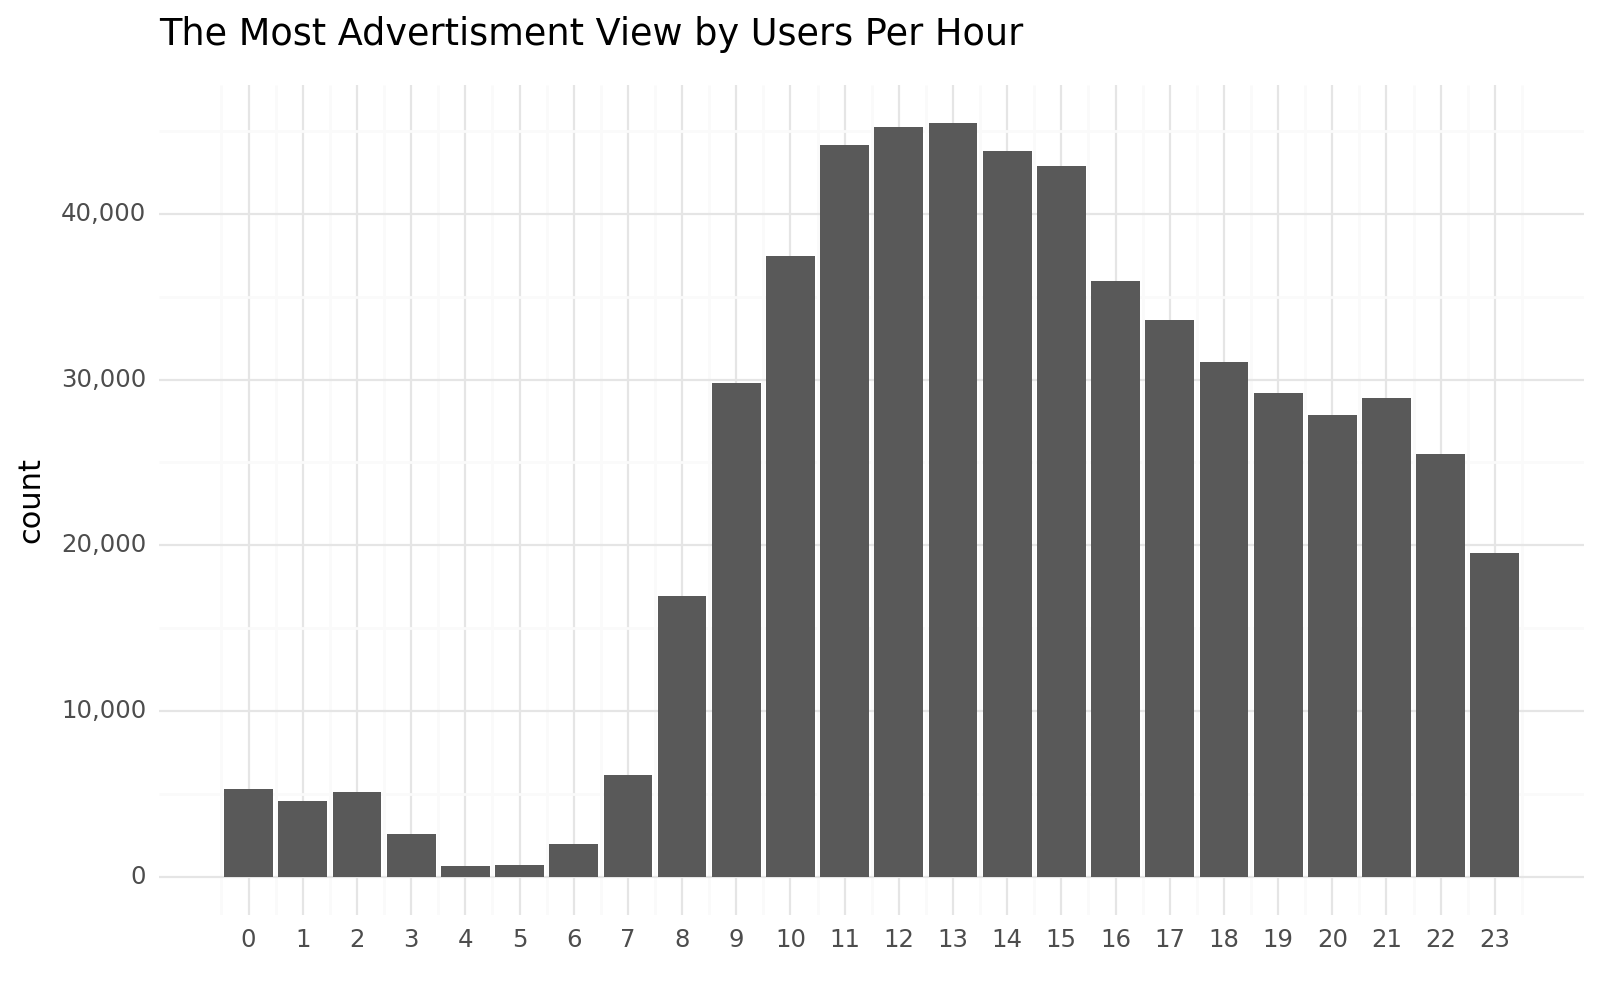

<Figure Size: (800 x 500)>

In [59]:
temp = c_df.query("group == 'Ads'")["most_views_hour"].value_counts(sort=False).reset_index()

(
    g.ggplot(temp, g.aes(x="most_views_hour", y="count")) +
    g.geom_col() +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l])  +
    g.scale_x_continuous(breaks = list(range(0, 24))) +
    g.labs(x="", title = "The Most Advertisment View by Users Per Hour") + 
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

The majority of users engaged with the most ads from 8 am until 11 pm, with a notable peak between 11 am and 3 pm, averaging around 44,301 users. Conversely, the period from midnight to 7 am recorded the lowest user engagement, with an average of approximately 3,407 users.

###### Conversion

In [75]:
temp = (
    df
    .query("group == 'ad'")
    .groupby("most_views_hour")
    .agg(
        total_converted=pd.NamedAgg(column="converted", aggfunc="sum"),
        num_users = pd.NamedAgg(column="most_views_hour", aggfunc="count")
    )
    .reset_index()
    .assign(conversion_rate = lambda _: round((_["total_converted"] / _["num_users"]) * 100, 3))
)

temp

,most_views_hour,total_converted,num_users,conversion_rate
0,0,102,5309,1.921
1,1,62,4615,1.343
2,2,39,5152,0.757
3,3,27,2590,1.042
4,4,11,694,1.585
5,5,16,742,2.156
6,6,46,1985,2.317
7,7,114,6168,1.848
8,8,337,16968,1.986
9,9,582,29802,1.953


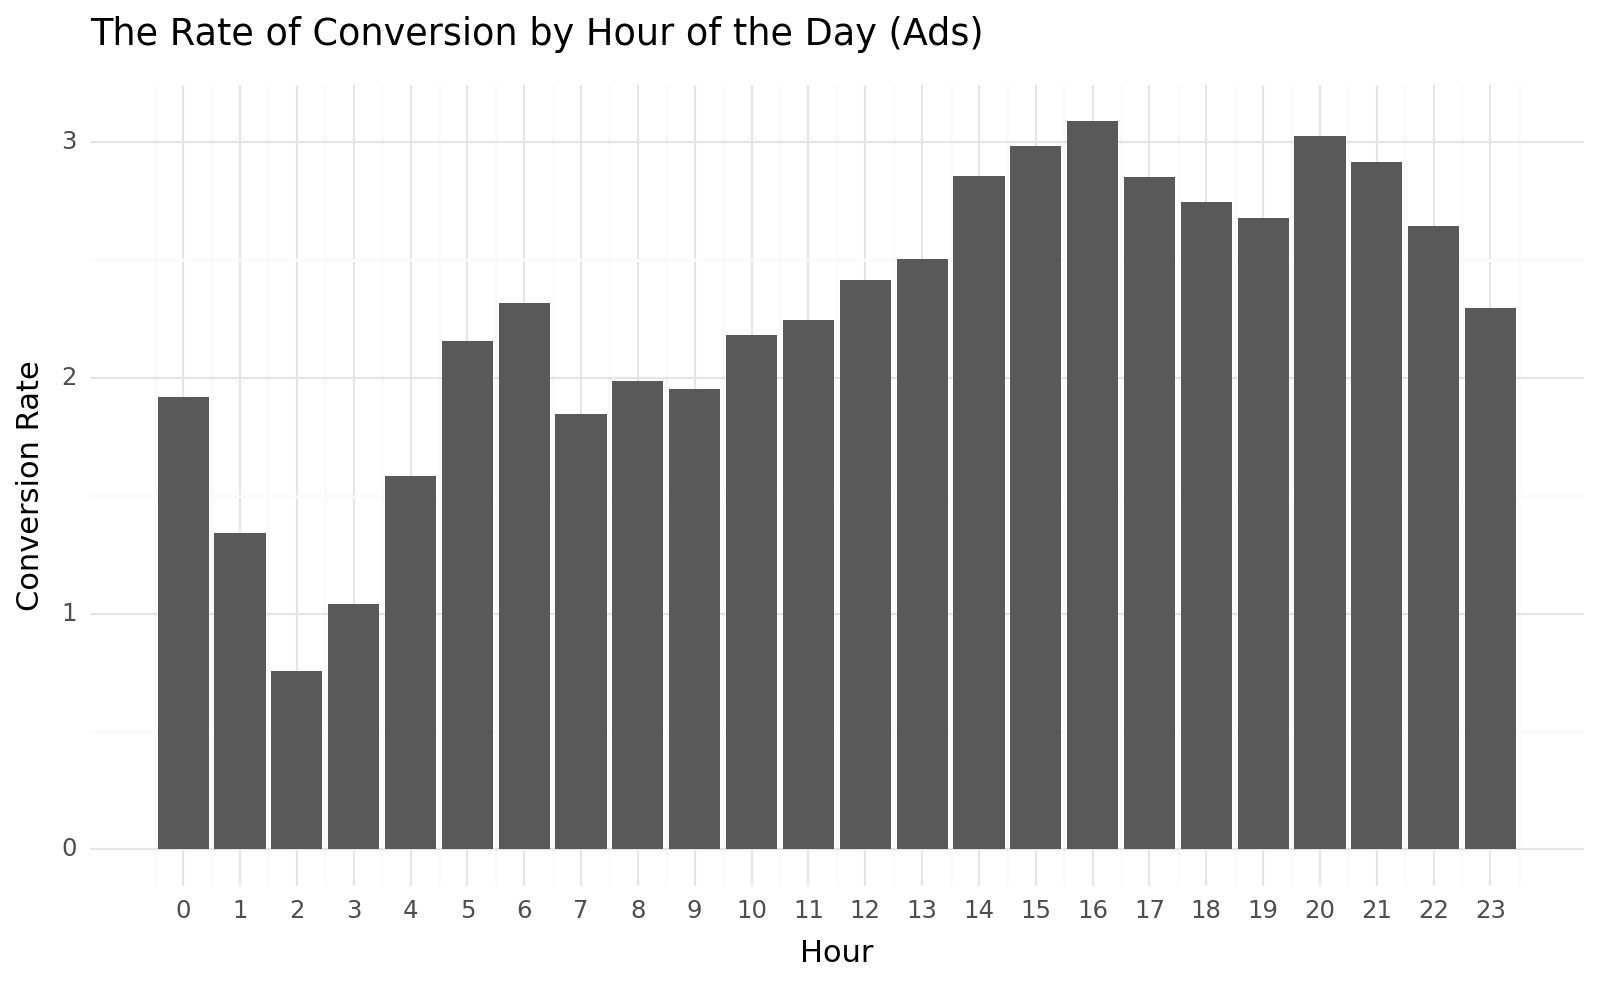

<Figure Size: (800 x 500)>

In [79]:
(
    g.ggplot(temp, g.aes(x="most_views_hour", y="conversion_rate")) +
    g.geom_col() +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l])  +
    g.scale_x_continuous(breaks = list(range(0, 24))) +
    g.labs(x="Hour", y="Conversion Rate", title = "The Rate of Conversion by Hour of the Day (Ads)") + 
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

Beginning at 9 am, there is a noticeable upward trend in conversion rates, reaching its peak between 2 pm and 4 pm. Subsequently, conversion rates begin to decline from 5 pm to 7 pm and again from 8 pm to 11 pm. These fluctuations could be naturally influenced by the varying levels of user activity during those hours.

##### PSA

In [65]:
(
    c_df.query("group == 'PSA'")["most_views_hour"]
        .value_counts()
        .reset_index()
        .assign(percentage = lambda _: round((_["count"] / _["count"].sum())*100, 3))
)

,most_views_hour,count,percentage
0,13,2170,9.225
1,11,2061,8.761
2,12,2060,8.757
3,14,1869,7.945
4,15,1828,7.771
5,16,1604,6.819
6,10,1485,6.313
7,17,1383,5.879
8,18,1271,5.403
9,9,1202,5.110


In [68]:
temp = (
    c_df.query("group == 'PSA'")["most_views_hour"]
        .value_counts()
        .reset_index()
        .assign(percentage = lambda _: round((_["count"] / _["count"].sum())*100, 3))
)


temp.query(f"most_views_hour in {list(range(8))}")["count"].mean()

131.875

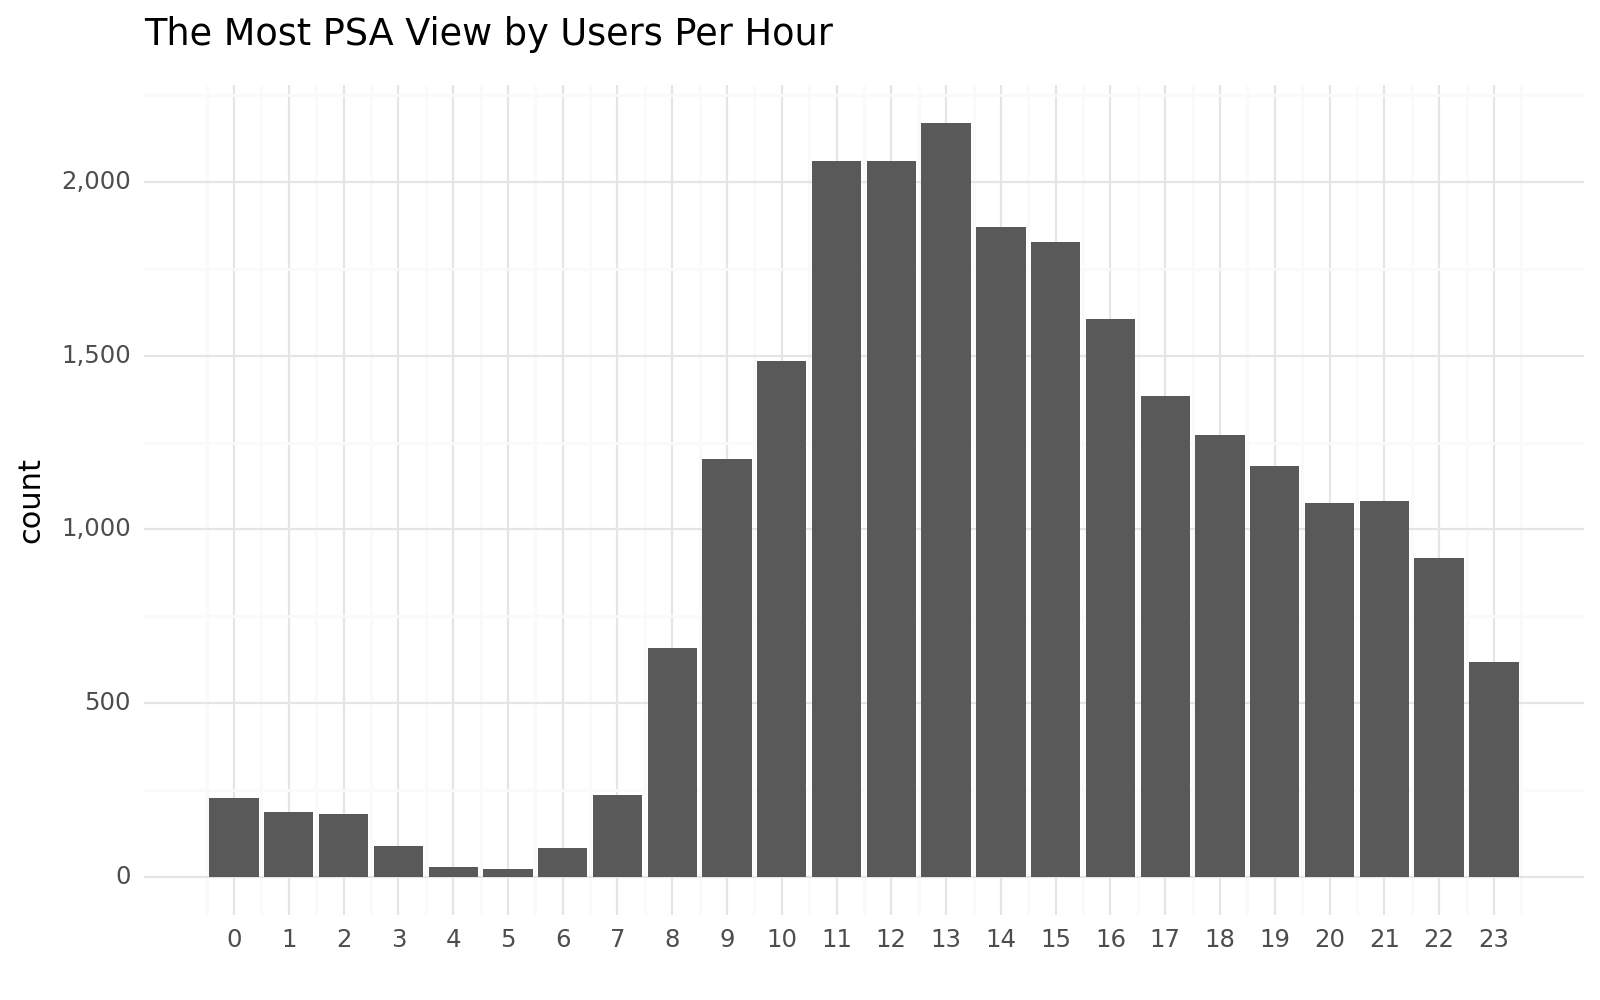

<Figure Size: (800 x 500)>

In [66]:
temp = c_df.query("group == 'PSA'")["most_views_hour"].value_counts(sort=False).reset_index()

(
    g.ggplot(temp, g.aes(x="most_views_hour", y="count")) +
    g.geom_col() +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l])  +
    g.scale_x_continuous(breaks = list(range(0, 24))) +
    g.labs(x="", title = "The Most PSA View by Users Per Hour") +
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

The user engagement pattern concerning the most-viewed PSA per hour closely mirrors that of the ads. The peak activity hours for users on the platform were between 11 am and 3 pm, with an average of around 1,997 users. Conversely, the period from midnight to 7 am registered the lowest user activity, as anticipated, with an average of approximately 131 users.

###### Conversion

In [80]:
temp = (
    df
    .query("group == 'psa'")
    .groupby("most_views_hour")
    .agg(
        total_converted=pd.NamedAgg(column="converted", aggfunc="sum"),
        num_users = pd.NamedAgg(column="most_views_hour", aggfunc="count")
    )
    .reset_index()
    .assign(conversion_rate = lambda _: round((_["total_converted"] / _["num_users"]) * 100, 3))
)

temp

,most_views_hour,total_converted,num_users,conversion_rate
0,0,0,227,0.000
1,1,0,187,0.000
2,2,0,181,0.000
3,3,1,89,1.124
4,4,0,28,0.000
5,5,0,23,0.000
6,6,0,83,0.000
7,7,2,237,0.844
8,8,7,659,1.062
9,9,13,1202,1.082


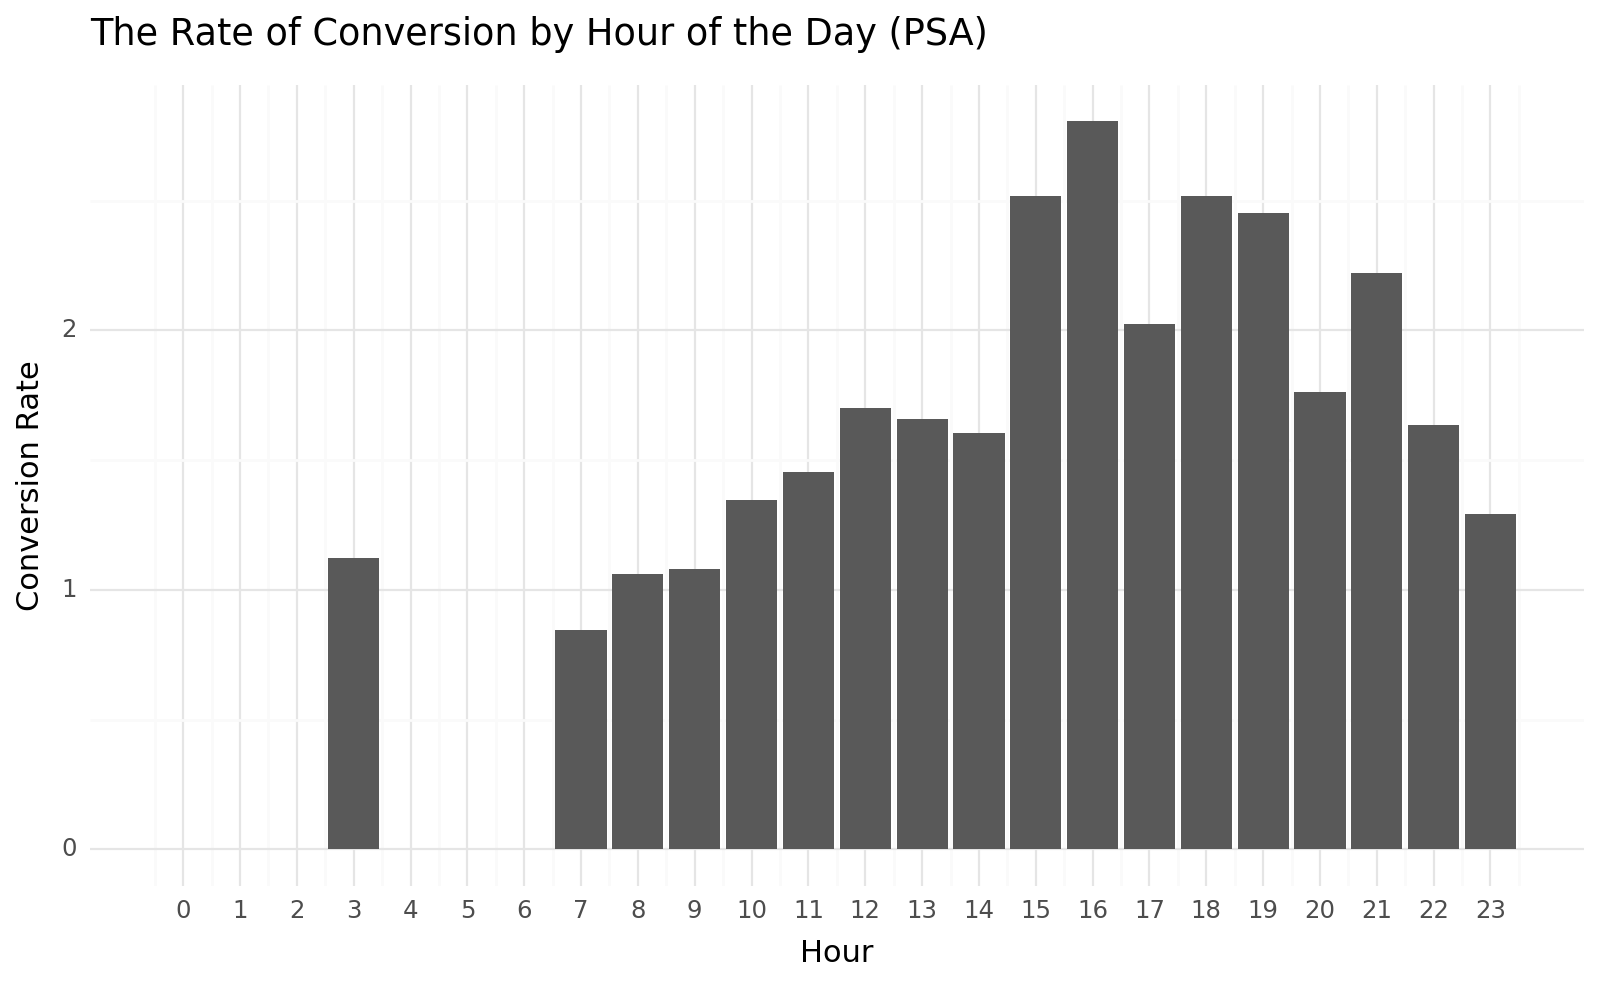

<Figure Size: (800 x 500)>

In [81]:
(
    g.ggplot(temp, g.aes(x="most_views_hour", y="conversion_rate")) +
    g.geom_col() +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l])  +
    g.scale_x_continuous(breaks = list(range(0, 24))) +
    g.labs(x="Hour", y="Conversion Rate", title = "The Rate of Conversion by Hour of the Day (PSA)") + 
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

Between midnight and 2 am, as well as at 6 am (excluding 3 am), the conversion plot indicates no converted users during these hours. The exception was at 3 am, where a single user out of 3 active users converted. Subsequently, from 8 am until noon, the conversion rate consistently increased. The highest conversion rates occurred from 3 pm to 7 pm, with a notable peak at 4 pm, and 9 pm also exhibited one of the highest conversion rates during this period.

**Does the display of advertisements correlate with the number of conversion of not?**

In [10]:
cross_table = pd.crosstab(
    df["group"],
    df["converted"],
    margins=True
)

cross_table

converted,0,1,All
group,,,
ad,550154,14423,564577
psa,23104,420,23524
All,573258,14843,588101


#### Hypothesis

* Null Hypothesis (H0): There is no correlation between the number of ads viewed and the conversion rate.
* Alternative Hypothesis (Ha): There is a correlation between the number of ads viewed and the conversion rate.

In [11]:
chi_sq, p_value, dof, expected = stats.chi2_contingency(cross_table)

print("Chi-Square statistic :", chi_sq)
print("P-Value :", p_value)
print("Degree of Freedom :", dof)
print("\nExpected Frequencies:")
print(expected)

Chi-Square statistic : 54.318051591383124
P-Value : 4.5144265218984724e-11
Degree of Freedom : 4

Expected Frequencies:
[[550327.71899045  14249.28100955 564577.        ]
 [ 22930.28100955    593.71899045  23524.        ]
 [573258.          14843.         588101.        ]]


* The chi-square statistic suggest a strong association between the number of ads viewed and the conversion rate.
* The very low p-value indicates that this association is highly unlikely to be due to random chance.
* Based on the results, you would likely reject the null hypothesis and conclude that there is a statistically significant correlation between the number of ads viewed and the conversion rate.

## Checking for statistical significence (Mean)

In [13]:
# Test Group 
test_group = df.query("group == 'ad'")

# Control Group
control_group = df.query("group == 'psa'")

In [32]:
(
    test_group
    .groupby("group")["converted"]
    .agg([np.mean, np.std])
    .reset_index()
)

,group,mean,std
0,ad,0.025547,0.157778


In [33]:
(
    control_group
    .groupby("group")["converted"]
    .agg([np.mean, np.std])
    .reset_index()
)

,group,mean,std
0,psa,0.017854,0.132424


**`Edit`**

* Users who saw the advertisement have a higher conversion on average compared to user who saw the public service announcement.
* There is slightly more variability in the conversion rates for users who saw the advertisement. 

## Checking for statistical significence (U-test)

##### Assumption of Normality

- H0: The distribution of the test and control group conversion is `Normal`.
- Ha: The distribution of the test and control group conversion is not `Normal`.

In [14]:
print("p-value of Test group (Ads) :", shapiro(test_group["converted"])[1])

print("p-value of Control group (PSA) :", shapiro(control_group["converted"])[1])

p-value of Test group (Ads) : 0.0
p-value of Control group (PSA) : 0.0


When assessing the normality assumption of the test and control group distribution, both distributions yielded p-value less than 0.05. Therefore, we will `reject the null hypothesis` that the distributions follow a normal pattern.

Since the distribution of both the test and control groups do not adhere to a normal pattern, we will opt for a non-parameteric approach, employing the Mann-Whitney U test to assess the difference in the conversation rate of the test and control groups.

### Hypothesis

Since the project goal is to figure out the 

* `Null hypothesis (H0)`: The conversion rate of the test group (Ads) is equal to or less than the conversion rate of the control group (PSA).

* `Alternative hypothesis (Ha)`: The conversion rate of the test group (Ads) is significantly greater that the conversion rate of the control group (PSA).

##### One sided U-test

As the project's objective is to assess if the advertisment leads to a significant inprovement in the conversion rate, conducting a on-tailed test would be a suitable approach.

In [38]:
u_statistic, p_value = stats.mannwhitneyu(test_group["converted"], control_group["converted"], alternative = "greater")

In [40]:
print("The Statistic : ", u_statistic)
print("The P-value: ", p_value)

The Statistic :  6691636830.0
The P-value:  8.526808965085939e-14


* The test statistics which measures the strength and direction of the difference between the two groups suggest a substantial difference in conversion rates.
* the very low p-value indicates that its extremely unlikely to observe this difference by random chance alone.

In conclusion, since the p-value is significantly smaller than the significant level of 0.05, we can reject the null hypothesis. This means that there is strong evidence to support the alternative hypothesis, indicating that users who saw the ads have a significantly diffenent and higher conversion rate compared to those who saw the PSA.

this is evidence that the advertisement has a positive impact on the conversion rate compared to  the public service announcement.

## Samples (Bootstrap)

Evidently, there is a substantial disparity in the sample size between the group exposed to the advertisement, comprising 96% of the total, and the group that viewed the PSA, which consitutes a mere 4%. When there is such an imbalance in sample size between experimental and control groups, it can potentially introduce several statistical analysis challenges. These imbalanced sample sizes can impact the statistical power of the analysis and the precision of the estimates. Specifically, the group with the larger sample size is likely to yield more precise estimates compared to the group with the smaller sample size. Therefore, in this scenario, it becomes crucial to consider strategies with approprate statistical techniques capable of addressing imbalanced sample size, including weighted analysis or resampling methods like bootstrapping.

In [41]:
boot_df = pd.DataFrame()

In [43]:
boot_ads = []

for i in range(1000):
    boot_mean = test_group.sample(frac=1, replace=True)["converted"].mean()

    boot_ads.append(boot_mean)


boot_df["ads_converted"] = boot_ads

In [46]:
boot_psa = []

for i in range(1000):
    boot_mean = control_group.sample(frac=1, replace=True)["converted"].mean()

    boot_psa.append(boot_mean)


boot_df["psa_converted"] = boot_psa

In [49]:
boot_df.head()

,ads_converted,psa_converted
0,0.025626,0.015899
1,0.025499,0.019257
2,0.025292,0.017259
3,0.025463,0.017642
4,0.025554,0.017301


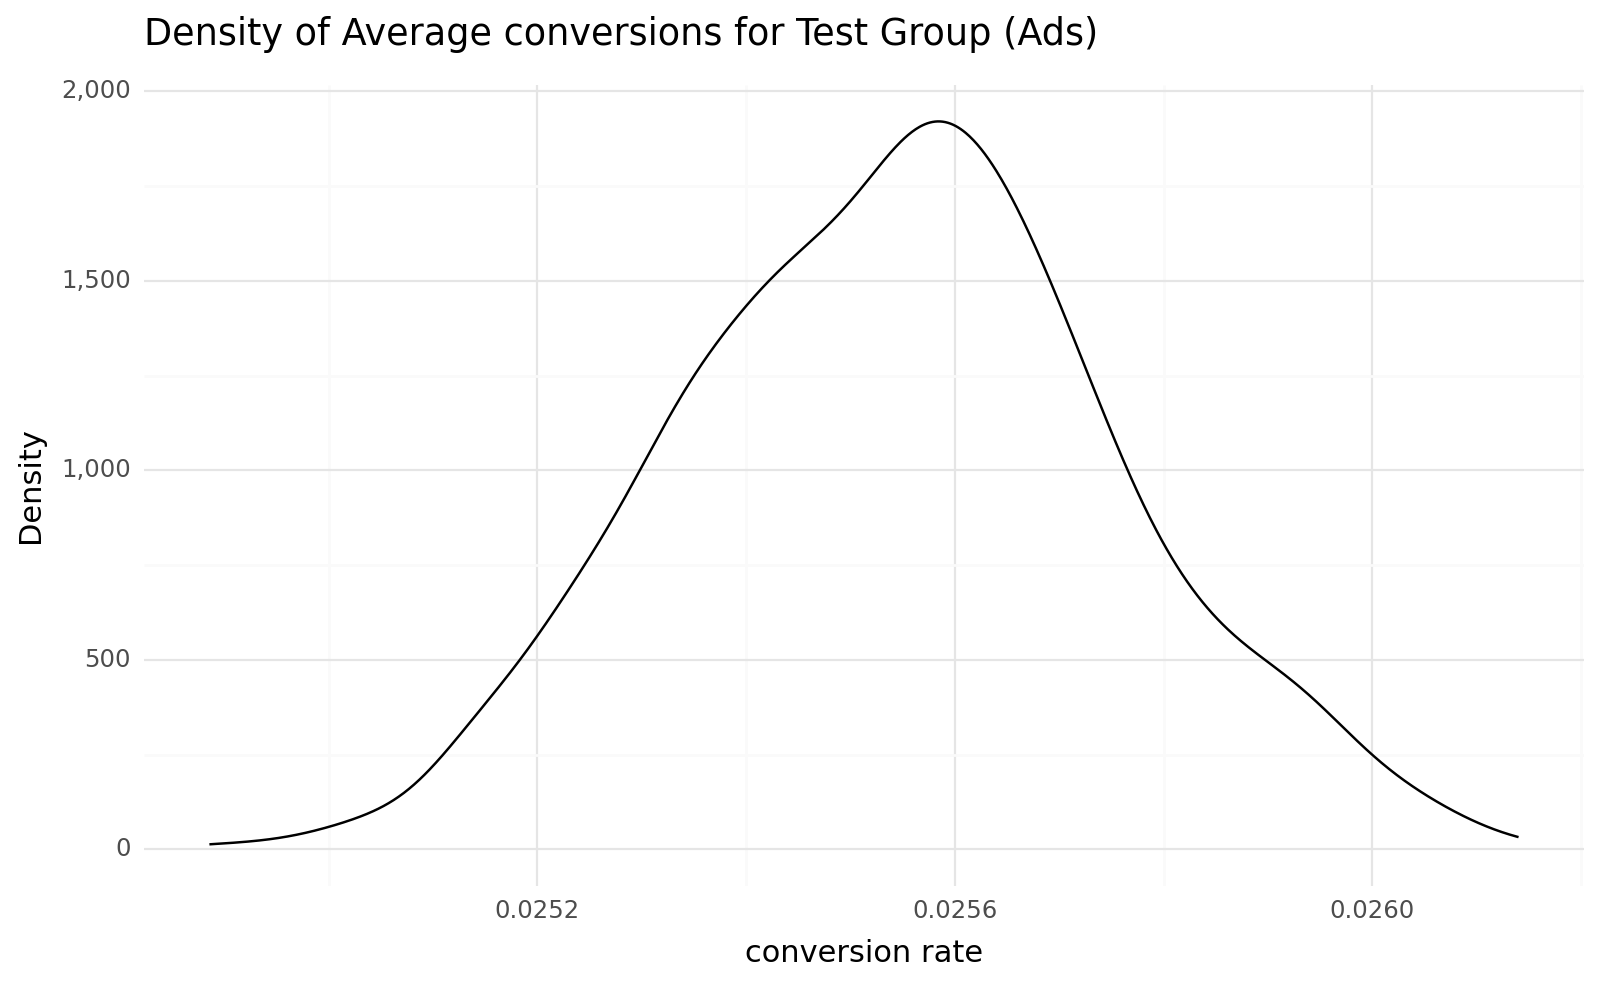

<Figure Size: (800 x 500)>

In [51]:
(
    g.ggplot(boot_df, g.aes(x='ads_converted')) +
    g.geom_density() +
    g.labs(
        x="conversion rate",
        y="Density",
        title="Density of Average conversions for Test Group (Ads)"
    ) +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l]) +
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

In [52]:
shapiro(boot_df["ads_converted"])

ShapiroResult(statistic=0.9982064962387085, pvalue=0.38011378049850464)

The p-value of `~0.380` (> 0.05 significant level) suggest that the sample distribution is normal and we will not reject the null hypothesis.

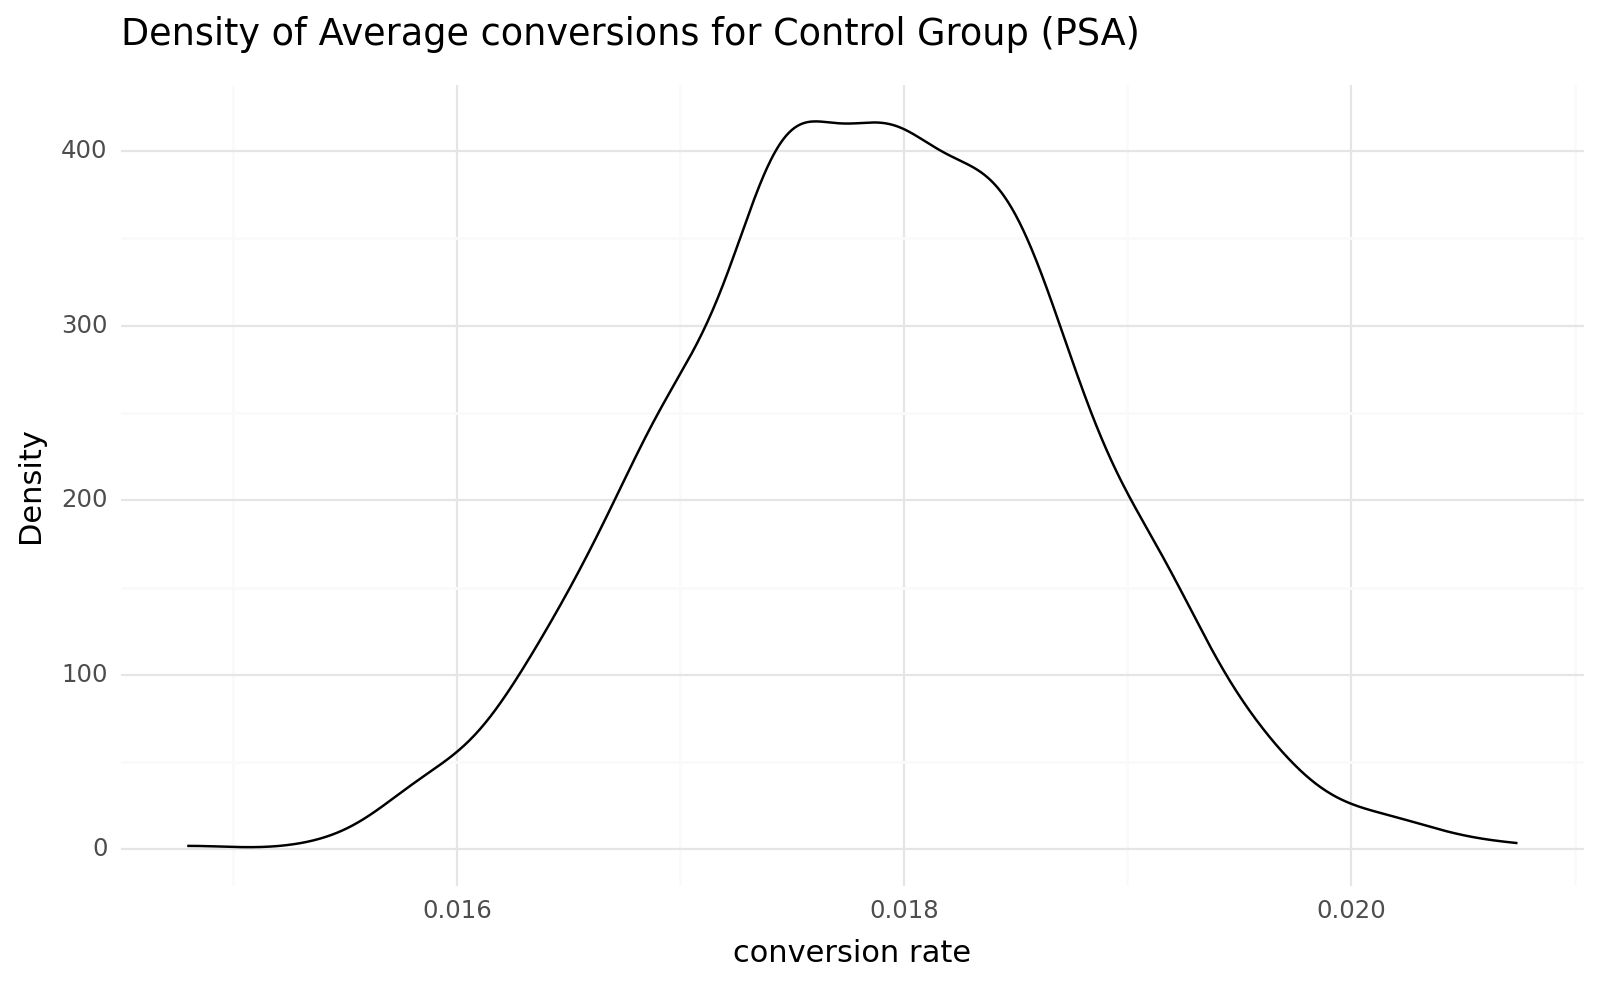

<Figure Size: (800 x 500)>

In [53]:
(
    g.ggplot(boot_df, g.aes(x='psa_converted')) +
    g.geom_density() +
    g.labs(
        x="conversion rate",
        y="Density",
        title="Density of Average conversions for Control Group (PSA)"
    ) +
    g.scale_y_continuous(labels = lambda l: ["{:,.0f}".format(v) for v in l]) +
    g.theme_minimal() +
    g.theme(figure_size=(8, 5))
)

In [54]:
shapiro(boot_df["psa_converted"])

ShapiroResult(statistic=0.9989401698112488, pvalue=0.8407437205314636)

Just like the samples for the test group, the p-value of `~0.841` (> 0.05 significant level) suggest that the sample distribution is normal and we will not reject the null hypothesis. (This allows for the application of statistical tests and confidence intervals that rely on the assumption of normality).

In [55]:
t_stat, p_value = stats.ttest_ind(
    boot_df["ads_converted"], 
    boot_df["psa_converted"], 
    alternative="greater", 
    equal_var=False
)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 264.89026310479414
P-value: 0.0


The `T-statistic` of **~264.89** which serves as indicator of the magnitude of the difference between the test and control groups is high enough, indicating a subtantial difference between the groups. While the `p-value` which is < 0.05 (significate level), is exceptionally low small, signifying an extremely low likelihood of observing this level of difference by random chance alone.

## Evaluation

Base on the results:

* Since the `p-value` is significantly less than the chosen significance level (0.05), the Null hypothesis is decisively rejected.
* This provides strong evidence in favor of the alternative hypothesis, indicating that there is a statistically significant difference between the test groups and the control group being compared.

In summary, the t-test results reveal a statistically significant difference between the test (users with Ads views) and control group (user with PSA views), with the t-statistic and p-value pointing to a subtantial distinction. This indicates that the advertisement has a significant impact on the conversion rate compared to the public service announcement.

## Recommendation


Following the evaluation of the significance indicating a higher conversion rate for the ads, here are three key recommendations:

**Optimize Ad Placement Strategy:**

The analysis indicates that the advertisement significantly outperforms the PSA in terms of conversion rate. To maximize this advantage, the company should consider strategic placement of ads during peak user engagement periods, based on the insights gathered regarding daily and hourly views. By aligning ad exposure with when users are most active, the company can enhance the chances of conversions and improve ROI.

**Segmentation for Targeted Marketing:**

Identify user groups that responded exceptionally well to the ads and tailor marketing strategies specifically for them. Understanding the demographics and behaviors of these high-conversion groups can help refine the message and target, thus boosting conversion rates.

**Continuous Monitoring and Adaptation:**

While the analysis provides compelling evidence of the ads' positive impact, to maintain and build upon these gains, it's crucial for the company to implement continuous monitoring of user behavior and adapt marketing strategies accordingly. Stay agile in responding to changing trends, user preferences, and competition to ensure sustained growth in conversion rates.

By implementing these recommendations, the company can not only capitalize on the current success of its advertising efforts but also lay the foundation for ongoing improvements and enhanced conversion rates. By implementing these recommendations, success in the advertising efforts can be capitalized and proper foundation layed for ongoing improvements and enhanced conversion rates.